In [1]:
# IMPORTS
import GDI
import numpy as np
import itertools
from multiprocessing import Pool
from functools import partial

/Users/joe/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# PARAMETERS
sample_sizes = np.asarray([300, 2000])
dim_sizes    = 2+np.asarray([0, 30])
boot_iter    = 10
num_runs     = 10

sim_type     = 'continuous'

# covariance for continuous
rho = 0.6 

# for discrete, effectiveness of synaptic transmission
p  = 0.1 
# prob of x spiking in a given time bin
Px = 0.3

In [3]:
# LOOP THROUGH SIMULATIONS
sample_sizes_list = [*range(sample_sizes.shape[0])]
dim_sizes_list = [*range(dim_sizes.shape[0])]
run_indice_list = np.arange(num_runs).tolist()

iter_list = list(itertools.product(sample_sizes_list, dim_sizes_list,run_indice_list))

In [4]:
iter_list

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 0, 5),
 (0, 0, 6),
 (0, 0, 7),
 (0, 0, 8),
 (0, 0, 9),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (0, 1, 8),
 (0, 1, 9),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 0, 5),
 (1, 0, 6),
 (1, 0, 7),
 (1, 0, 8),
 (1, 0, 9),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 1, 5),
 (1, 1, 6),
 (1, 1, 7),
 (1, 1, 8),
 (1, 1, 9)]

In [5]:
# DEFINE FUNCTION FOR SCALING
def scaling_fun(sample_sizes,dim_sizes,boot_iter,sim_type,rho,p,Px,sim_conditions):
    # EXTRACT SIM CONDITIONS
    N = sample_sizes[sim_conditions[0]]
    dz = dim_sizes[sim_conditions[1]]
    print(N)
    # SIMULATE
    # DISCRETE
    if sim_type=='discrete':
        X = np.random.binomial(1,0.5,(N,dz))
        X[:,0] = np.random.binomial(1,Px,(N,))
        error_bit_stream = np.random.binomial(1,1-p,(N,))
        X[:,1] = (error_bit_stream*X[:,0])+((1-error_bit_stream)*(1-X[:,0]))
    
    # CONTINUOUS
    elif sim_type=='continuous':
        # COVARIANCE
        cov_mat = np.eye(dz)
        cov_mat[0,1] = rho
        cov_mat[1,0] = rho
        
        # GENERATE DATA
        X = np.random.multivariate_normal(np.zeros((dz,)), cov_mat, int(N))
    
    # UNSUPPORTED
    else:
        raise NameError('sim_type specified by user not supported')
    
    # SHIFT FOR CAUSALITY
    X[1:,1] = X[:-1,1]
    
    # REMOVE EXCESS SAMPLES AT END
    M = 1
    num_channels = X.shape[1]
    num_samples = X.shape[0]
    num_windows = int(np.floor(num_samples/(M+1)))
    num_samples_to_keep = int(num_windows*(M+1))
    X_trim = X[:num_samples_to_keep,:]

    # RESHAPE SO THAT MATRIX HAS DIM:
    #   (samples)x(X1(-M+i),X1(-M+1+i),...,X1(i),X2(-M+1),X2(-M+1+i),...)
    # WHERE EACH SAMPLE CORRESPONDS TO A WINDOW
    X_past_win = np.zeros((num_windows,num_channels*M))
    X_current  = np.zeros((num_windows,num_channels))
    for chan in range(num_channels):
        current_chan_mat = np.reshape(X_trim[:,chan],(num_windows,(M+1)))
        X_past_win[:,(chan*M):((chan+1)*M)] = current_chan_mat[:,:M]
        X_current[:,chan] = current_chan_mat[:,M]
    
    # ESTIMATE GDI
    GDI_est = GDI.pair_GDI(X_past_win,X_current,M,boot_iter,(0,1))
    
    # RETURN ESTIMATE
    return GDI_est

In [6]:
# RUN ITERATIONS OF SCALING ANALYSIS IN PARALLEL
pool = Pool()
func = partial(scaling_fun,sample_sizes,dim_sizes,boot_iter,sim_type,rho,p,Px)
GDI_estimate_list = pool.map(func,iter_list)

300
300
300
300
300
300
300
300
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan


W0926 17:41:46.040923 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/CCMI.py:79: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.
W0926 17:41:46.042639 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/CCMI.py:79: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.
W0926 17:41:46.043252 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/CCMI.py:79: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.


W0926 17:41:46.043598 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/CCMI.py:79: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.




Tester = Classifier, metric = donsker_varadhan


W0926 17:41:46.054121 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/Classifier_MI.py:66: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.
W0926 17:41:46.053881 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/Classifier_MI.py:66: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.
W0926 17:41:46.056930 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/Classifier_MI.py:66: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.
W0926 17:41:46.055423 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/Classifier_MI.py:66: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.




W0926 17:41:46.055419 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/CCMI.py:79: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0926 17:41:4

Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan


W0926 17:41:46.100387 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/Classifier_MI.py:49: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.
W0926 17:41:46.099450 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/CCMI.py:79: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0926 17:41:46.099938 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/CCMI.py:79: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.


W0926 17:41:46.111155 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/Classifier_MI.py:66: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


Tester = Classifier, metric = donsker_varadhan


W0926 17:41:46.112933 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/Classifier_MI.py:66: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


W0926 17:41:46.115808 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/CCMI.py:79: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0926 17:41:46.127578 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/Classifier_MI.py:66: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.
W0926 17:41:46.127872 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/Classifier_MI.py:49: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0926 17:41:46.130455 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/Classifier_MI.py:49: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.






W0926 17:41:47.368198 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/Classifier_MI.py:84: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.
W0926 17:41:47.367493 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/Classifier_MI.py:87: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.
W0926 17:41:47.372794 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/Classifier_MI.py:87: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0926 17:41:47.373673 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/Classifier_MI.py:87: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



W0926 17:41:47.378762 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/Classifier_MI.py:87: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0926 17:41:47.390228 4383866304 deprecation_wrapp

300
Tester = Classifier, metric = donsker_varadhan
300
Tester = Classifier, metric = donsker_varadhan
300
Tester = Classifier, metric = donsker_varadhan
300
Tester = Classifier, metric = donsker_varadhan
300
Tester = Classifier, metric = donsker_varadhan
300
Tester = Classifier, metric = donsker_varadhan
300
Tester = Classifier, metric = donsker_varadhan
300
Tester = Classifier, metric = donsker_varadhan
300
Tester = Classifier, metric = donsker_varadhan
300
2000
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
2000
Tester = Classifier, metric = donsker_varadhan
2000
Tester = Classifier, metric = donsker_varadhan
2000
Tester = Classifier, metric = donsker_varadhan
2000
Tester = Classifier, metric = donsker_varadhan
2000
Tester = Classifier, metric = donsker_varadhan
300
Tester = Classifier, metric = donsker_varadhan
300
Tester = Classifier, metric = donsker_varadhan
2000
Tester = Classifier, metric = donsker_varadhan
2000
Tester = Classifier

In [7]:
# UNWRAP SCALING RESULTS
GDI_estimates_unwrapped = np.zeros((sample_sizes.shape[0],dim_sizes.shape[0],num_runs))
for ii in range(len(GDI_estimate_list)):
    GDI_estimates_unwrapped[iter_list[ii][0],iter_list[ii][1],iter_list[ii][2]] = GDI_estimate_list[ii]

In [8]:
# TRUE GDI
if sim_type=='continuous':
    true_GDI = -0.5*np.log(1-(rho**2))
elif sim_type=='discrete':
    # JOINT
    px1y1 = Px*(1-p)
    px1y0 = Px*p
    px0y1 = (1-Px)*p
    px0y0 = (1-Px)*(1-p)
    # MARGINAL
    py1 = px1y1+px0y1
    py0 = px1y0+px0y0
    px1 = px1y1+px1y0
    px0 = px0y1+px0y0
    # GDI
    true_GDI = (px1y1*np.log(px1y1/(px1*py1)))+(px1y0*np.log(px1y0/(px1*py0)))+(px0y1*np.log(px0y1/(px0*py1)))+(px0y0*np.log(px0y0/(px0*py0)))

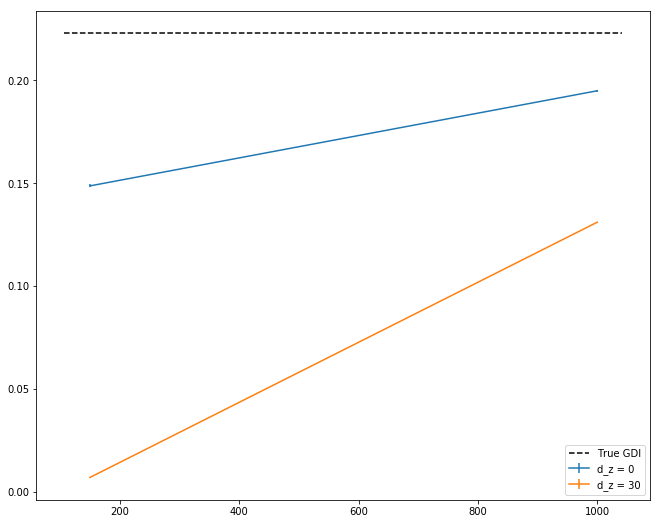

In [12]:
# NOTE THAT WE DIVIDE SAMPLE_SIZES BY 2 IN PLOTTING, 
# SINCE THIS REFERS TO THE ACTUAL NUMBER OF SAMPLES USED IN ESTIMATION
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(11, 9))
for ii in range(dim_sizes.shape[0]):
    plt.errorbar(sample_sizes/2, np.mean(np.squeeze(GDI_estimates_unwrapped[:,ii,:]),axis=1), 
                 yerr=np.var(np.squeeze(GDI_estimates_unwrapped[:,ii,:]),axis=1), label='d_z = %i'%(dim_sizes[ii]-2))

plt.hlines(true_GDI,int(plt.xlim()[0]),int(plt.xlim()[1]),linestyles='dashed',label='True GDI')
plt.legend(loc='lower right')

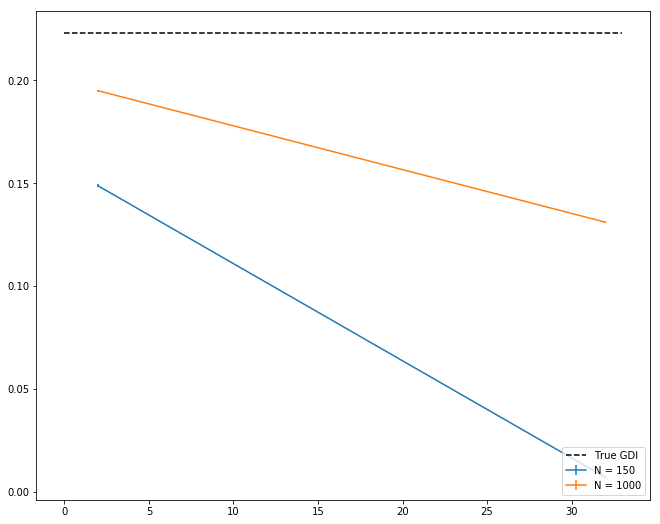

In [13]:
# NOTE THAT WE DIVIDE SAMPLE_SIZES BY 2 IN PLOTTING, 
# SINCE THIS REFERS TO THE ACTUAL NUMBER OF SAMPLES USED IN ESTIMATION
f, ax = plt.subplots(figsize=(11, 9))
for ii in range(sample_sizes.shape[0]):
    plt.errorbar(dim_sizes, np.mean(np.squeeze(GDI_estimates_unwrapped[ii,:,:]),axis=1), 
                 yerr=np.var(np.squeeze(GDI_estimates_unwrapped[ii,:,:]),axis=1), label='N = %i'%(sample_sizes[ii]/2))

plt.hlines(true_GDI,int(plt.xlim()[0]),int(plt.xlim()[1]),linestyles='dashed',label='True GDI')
plt.legend(loc='lower right')

In [14]:
# RESET SOME PARAMETERS FOR BOOTSTRAPPING ANALYSIS
sample_sizes = np.asarray([5000])
dim_sizes    = np.asarray([2])
boot_iter    = 10
num_runs     = 50

In [15]:
# REDEFINE FUNCTION FOR SCALING
def scaling_fun(sample_sizes,dim_sizes,boot_iter,sim_type,rho,p,Px,sim_conditions):
    # EXTRACT SIM CONDITIONS
    N = sample_sizes[sim_conditions[0]]
    dz = dim_sizes[sim_conditions[1]]
    print(N)
    # SIMULATE
    # DISCRETE
    if sim_type=='discrete':
        X = np.random.binomial(1,0.5,(N,dz))
        X[:,0] = np.random.binomial(1,Px,(N,))
        error_bit_stream = np.random.binomial(1,1-p,(N,))
        X[:,1] = (error_bit_stream*X[:,0])+((1-error_bit_stream)*(1-X[:,0]))
    
    # CONTINUOUS
    elif sim_type=='continuous':
        # COVARIANCE
        cov_mat = np.eye(dz)
        cov_mat[0,1] = rho
        cov_mat[1,0] = rho
        
        # GENERATE DATA
        X = np.random.multivariate_normal(np.zeros((dz,)), cov_mat, int(N))
    
    # UNSUPPORTED
    else:
        raise NameError('sim_type specified by user not supported')
    
    # SHIFT FOR CAUSALITY
    X[1:,1] = X[:-1,1]
    
    # REMOVE EXCESS SAMPLES AT END
    M = 1
    num_channels = X.shape[1]
    num_samples = X.shape[0]
    num_windows = int(np.floor(num_samples/(M+1)))
    num_samples_to_keep = int(num_windows*(M+1))
    X_trim = X[:num_samples_to_keep,:]

    # RESHAPE SO THAT MATRIX HAS DIM:
    #   (samples)x(X1(-M+i),X1(-M+1+i),...,X1(i),X2(-M+1),X2(-M+1+i),...)
    # WHERE EACH SAMPLE CORRESPONDS TO A WINDOW
    X_past_win = np.zeros((num_windows,num_channels*M))
    X_current  = np.zeros((num_windows,num_channels))
    for chan in range(num_channels):
        current_chan_mat = np.reshape(X_trim[:,chan],(num_windows,(M+1)))
        X_past_win[:,(chan*M):((chan+1)*M)] = current_chan_mat[:,:M]
        X_current[:,chan] = current_chan_mat[:,M]
    
    # ESTIMATE GDI
    GDI_est = np.zeros((boot_iter,))
    for ii in range(boot_iter):
        GDI_est[ii] = GDI.pair_GDI(X_past_win,X_current,M,1,(0,1))
    
    # RETURN ESTIMATE
    return GDI_est

In [16]:
GDI_boot_analysis = np.zeros((num_runs,boot_iter))
sim_conditions = (0,0)
for ii in range(num_runs):
    GDI_boot_analysis[ii,:]=scaling_fun(sample_sizes,dim_sizes,boot_iter,sim_type,rho,p,Px,sim_conditions)

W0927 12:21:54.495897 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/CCMI.py:79: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0927 12:21:54.523134 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/Classifier_MI.py:66: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



5000
Tester = Classifier, metric = donsker_varadhan


W0927 12:21:54.617664 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/Classifier_MI.py:49: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0927 12:21:55.353579 4383866304 deprecation.py:323] From /Users/joe/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0927 12:21:55.361042 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/Classifier_MI.py:71: The name tf.losses.get_regularization_loss is deprecated. Please use tf.compat.v1.losses.get_regularization_loss instead.

W0927 12:21:55.371106 4383866304 deprecation_wrapper.py:119] From /Users/joe/GDI_Code_Dev/Classifier_MI.py:81: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamO

Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
5000
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
5000
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tes

Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
5000
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
5000
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tes

Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
5000
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
5000
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tes

In [ ]:
# PLOT ESTIMATE AS A FUNCTION OF BOOTSTRAP ITERATIONS
f, ax = plt.subplots(figsize=(11, 9))
for ii in range(num_runs):
    plt.plot(np.arange(boot_iter)+1, np.cumsum(GDI_boot_analysis[ii,:])/(np.arange(boot_iter)+1), 
               label='Run = %i'%ii)

plt.hlines(true_GDI,int(plt.xlim()[0]),int(plt.xlim()[1]),linestyles='dashed',label='True GDI')
plt.legend(loc='lower right')